## 01 Exploratory Data Analysis + Data Preparation

### Environment

Designed for Python 3.11.9 on Windows 10

##### Install Dependencies

In [ ]:
# Install from requirements.txt
!python -m pip install -r requirements.txt

In [ ]:
# Alternative for running in Colab etc
!pip install --upgrade pip
!pip install numpy==1.24.1
!pip install pmdarima==2.0.4
!pip install ibis-framework[duckdb]==9.5.0
!pip install pandas==2.2.3
!pip install matplotlib==3.9.2
!pip install skforecast==0.14.0

### Load and Preprocess Data

##### Imports

Key tools:
- [Ibis](https://ibis-project.org/) on a [DuckDB](https://duckdb.org/) backend with transformations to [Pandas](https://pandas.pydata.org/docs/index.html) for certain operations.
- Some excessively-verbose functions spun out to a data prep module 

In [1]:
import numpy as np
import pandas as pd
import ibis
import matplotlib.pyplot as plt
import methods.prep as prep
import methods.vis as vis
import importlib

In [32]:
importlib.reload(vis)
importlib.reload(prep)

<module 'methods.prep' from 'c:\\Users\\haits\\projects\\ea-nasir\\methods\\prep.py'>

##### Load Individual Datasets

In [2]:
con = ibis.connect("duckdb://")
data_path = 'data_staged/'

In [3]:
# Load FRED datasets
fred_dataset_names = [
    'CSENT',
    'CPI',
    'POP',
    'WAGE',
    'HOUSEPRICE',
    'HOUSESTARTS',
    'UNEMPLOYMENT',
]

fred_datasets = {}

print('\nFRED Datasets (single-variable time series)')
for name in fred_dataset_names:
    fred_datasets[name] = ibis.read_csv(
        data_path + name + '.csv',
        dateformat='%m/%d/%Y')
    print(name + ': ' + str(fred_datasets[name].to_pandas().shape))


FRED Datasets (single-variable time series)
CSENT: (864, 2)
CPI: (934, 2)
POP: (790, 2)
WAGE: (224, 2)
HOUSEPRICE: (247, 2)
HOUSESTARTS: (790, 2)
UNEMPLOYMENT: (922, 2)


In [ ]:
for k,v in fred_datasets.items():
    print(k)
    print(v.to_pandas().head())

In [4]:
# Load investing.com datasets

inv_dataset_names = [
    'COPPER', 
    'CORN', 
    'GOLD',
    'LUMBER',
    'NATGAS',
    'OIL',
    'R2000', 
    'SOY',
    'SP500',
    'VIX'
]

traded_commodities = [
    'COPPER'
]

inv_datasets = {}

print('Investing.com Datasets (standard prices and volume time series)')
for name in inv_dataset_names:
    inv_datasets[name] = ibis.read_csv(
        data_path + name + '.csv',
        dateformat='%m/%d/%Y')
    print(name + ': ' + str(inv_datasets[name].to_pandas().shape))
    

Investing.com Datasets (standard prices and volume time series)
COPPER: (4868, 7)
CORN: (4819, 7)
GOLD: (4820, 7)
LUMBER: (4829, 7)
NATGAS: (4897, 7)
OIL: (4917, 7)
R2000: (5000, 7)
SOY: (4939, 7)
SP500: (4769, 7)
VIX: (4794, 7)


In [ ]:
for k,v in inv_datasets.items():
    print(v.to_pandas().head())

##### Initial Preprocessing - Individual Datasets

In [5]:
# Fix column names in FRED data and drop unused rows
for dataset_name in fred_datasets.keys():
    old_col_name = fred_datasets[dataset_name].columns[1]
    
    fred_datasets[dataset_name] = fred_datasets[dataset_name].rename({dataset_name: old_col_name})

    #Convert timestamps to dates
    fred_datasets[dataset_name] = fred_datasets[dataset_name].mutate(
        DATE = fred_datasets[dataset_name]['DATE'].cast('date'))

    #Convert to all caps
    fred_datasets[dataset_name] = fred_datasets[dataset_name].rename('ALL_CAPS')

    #Drop unused rows - but keep some in 2006 to support forward fill
    fred_datasets[dataset_name] = fred_datasets[dataset_name].filter(fred_datasets[dataset_name].DATE.year() > 2005)


In [6]:
# Convert string to float64 in consumer sentiment data   
fred_datasets['CSENT'] = fred_datasets['CSENT'].mutate(
    CSENT = fred_datasets['CSENT']['CSENT'].replace(',','').cast('float64'))

In [ ]:
for k,v in fred_datasets.items():
    print(k)
    print(v.to_pandas().head())

In [ ]:
for k,v in fred_datasets.items():
    print(k)
    print(v.to_pandas().dtypes)

In [7]:
# Fix column names in Investing.com data and drop unused rows
for dataset_name in inv_datasets.keys():
    #Drop unnecessary columns
    inv_datasets[dataset_name] = inv_datasets[dataset_name].drop('Vol.','Change %')

    #Add trading day flag to traded columns
    if dataset_name in traded_commodities:
        inv_datasets[dataset_name] = inv_datasets[dataset_name].mutate(
            TRADING_DAY = True
        )

    #Convert column names to ALL CAPS
    inv_datasets[dataset_name] = inv_datasets[dataset_name].rename('ALL_CAPS')

    # Convert PRICE, OPEN, HIGH, and LOW to float64s if they are strings
    if inv_datasets[dataset_name]['PRICE'].type().is_string():
        inv_datasets[dataset_name] = inv_datasets[dataset_name].mutate(
            PRICE = inv_datasets[dataset_name]['PRICE'].replace(',','').cast('float64'))    

    if inv_datasets[dataset_name]['OPEN'].type().is_string():
        inv_datasets[dataset_name] = inv_datasets[dataset_name].mutate(
            OPEN = inv_datasets[dataset_name]['OPEN'].replace(',','').cast('float64'))   

    if inv_datasets[dataset_name]['HIGH'].type().is_string():
        inv_datasets[dataset_name] = inv_datasets[dataset_name].mutate(
            HIGH = inv_datasets[dataset_name]['HIGH'].replace(',','').cast('float64'))  

    if inv_datasets[dataset_name]['LOW'].type().is_string():
        inv_datasets[dataset_name] = inv_datasets[dataset_name].mutate(
            LOW = inv_datasets[dataset_name]['LOW'].replace(',','').cast('float64'))   

    # Add prefixes to each column based on the name of the dataset
    names_map = {
        f"{dataset_name}_{col}" : col 
            for col in inv_datasets[dataset_name].columns
            if col != 'DATE'}
    inv_datasets[dataset_name] = inv_datasets[dataset_name].rename(names_map)



In [ ]:
for k,v in inv_datasets.items():
    print(k)
    print(v.to_pandas().head())

In [ ]:
for k,v in inv_datasets.items():
    print(k)
    print(v.to_pandas().dtypes)

##### Merge Datasets, Fill Dates, and Forward Fill Missing Numeric Data

While the datasets span the 2007-2024Q3 date range, many dates within this range are missing, and the specific dates covered by each dataset vary. 

In [8]:
import datetime
# Merge all tables from the Investing.com dataset
inv_data = prep.merge_tables(
    inv_datasets, 
    join_type = 'outer',
    add_names=False)

# Merge all tables from the FRED dataset together
fred_data = prep.merge_tables(
    fred_datasets, 
    join_type = 'outer',
    add_names=False)

# Filter out early nulls from FRED
fred_data = fred_data.filter(fred_data.DATE.year() > 2006)

# Create a table with all of the dates in range
daterange = []
current_date = datetime.date(2006,1,1)
while current_date <= datetime.date(2024, 10, 31):
    daterange.append(current_date)
    current_date = current_date + datetime.timedelta(days=1)
daterange = pd.DataFrame(daterange, columns=['DATE'])

# Finally, merge the investing.com, FRED data, and daterange
# using an outer join to ensure there is a row for every date
data = prep.merge_tables(
    {
        'inv' : inv_data, 
        'fred' : fred_data,
        'dates': daterange
    },
    join_type='outer',
    add_names=False)

# Forward-fill impute all numeric data 
data = prep.impute_forward_fill_numerics(
    data = data,
    sort_by = 'DATE')

In [9]:
df = data.filter(data.DATE.year() >= 2007).filter(data.DATE.year() <= 2019).to_pandas()
print(df.shape)
print(df.isna().sum())

(4748, 49)
DATE                     0
COPPER_PRICE             0
COPPER_OPEN              0
COPPER_HIGH              0
COPPER_LOW               0
COPPER_TRADING_DAY    1451
CORN_PRICE               0
CORN_OPEN                0
CORN_HIGH                0
CORN_LOW                 0
GOLD_PRICE               0
GOLD_OPEN                0
GOLD_HIGH                0
GOLD_LOW                 0
LUMBER_PRICE             0
LUMBER_OPEN              0
LUMBER_HIGH              0
LUMBER_LOW               0
NATGAS_PRICE             0
NATGAS_OPEN              0
NATGAS_HIGH              0
NATGAS_LOW               0
OIL_PRICE                0
OIL_OPEN                 0
OIL_HIGH                 0
OIL_LOW                  0
R2000_PRICE              0
R2000_OPEN               0
R2000_HIGH               0
R2000_LOW                0
SOY_PRICE                0
SOY_OPEN                 0
SOY_HIGH                 0
SOY_LOW                  0
SP500_PRICE              0
SP500_OPEN               0
SP500_HIGH       

##### Data Availability Corrections

Data that is not yet available at prediction time can't be used to make predictions.  Many macroeconomic indicators are unavailable for weeks or months after the dates they pertain to as the underlying data must be reported and processed.  We'll avoid this concern altogether by lagging all macroeconomic indicators by 90 days.  Time permitting, this will be revisited.

In [10]:
macro_indicators = {
    'CSENT' : 90,
    'CPI' : 90,
    'POP' : 90,
    'WAGE' : 90,
    'HOUSEPRICE' : 90,
    'HOUSESTARTS' : 90,
    'UNEMPLOYMENT' : 90,
}

df = data.to_pandas().sort_values('DATE')

new_column_names = [col_name + '_LAG90' for col_name in macro_indicators.keys()]

df[new_column_names] = df[macro_indicators.keys()].shift(90)

data = ibis.memtable(df)


In [11]:
for item in macro_indicators.keys():
    data = data.rename({item+'_NOLAG' : item})

In [12]:
data.to_pandas().sort_values('DATE', ascending=False).head()

DATE  COPPER_PRICE  COPPER_OPEN  COPPER_HIGH  COPPER_LOW  \
6921  2024-11-22        4.0785       4.1050       4.1188      4.0608   
6920  2024-11-21        4.1250       4.1530       4.1665      4.0970   
6919  2024-11-20        4.1555       4.1660       4.1790      4.1365   
6918  2024-11-19        4.1420       4.1240       4.1745      4.0885   
6917  2024-11-18        4.1200       4.0665       4.1355      4.0505   

     COPPER_TRADING_DAY  CORN_PRICE  CORN_OPEN  CORN_HIGH  CORN_LOW  ...  \
6921               True      427.30     426.90      429.4    426.10  ...   
6920               True      426.75     430.00      432.0    426.25  ...   
6919               True      430.25     427.00      432.0    424.75  ...   
6918               True      427.25     428.75      431.5    426.50  ...   
6917               True      429.25     423.75      429.5    422.25  ...   

      HOUSEPRICE_NOLAG  HOUSESTARTS_NOLAG  UNEMPLOYMENT_NOLAG  CSENT_LAG90  \
6921          420400.0             1311.0                 4.1         67.9   
6920          420400.0             1311.0                 4.1         67.9   
6919          420400.0             1311.0                 4.1         67.9   
6918          420400.0             1311.0                 4.1         67.9   
6917          420400.0             1311.0                 4.1         67.9   

      CPI_LAG90  POP_LAG90  WAGE_LAG90  HOUSEPRICE_LAG90  HOUSESTARTS_LAG90  \
6921    314.121   337185.0       35.22          420400.0             1379.0   
6920    314.121   337185.0       35.22          420400.0             1379.0   
6919    314.121   337185.0       35.22          420400.0             1379.0   
6918    314.121   337185.0       35.22          420400.0             1379.0   
6917    314.121   337185.0       35.22          420400.0             1379.0   

      UNEMPLOYMENT_LAG90  
6921                 4.2  
6920                 4.2  
6919                 4.2  
6918                 4.2  
6917                 4.2  

[5 rows x 56 columns]

In [ ]:
print(data.to_pandas().isna().sum())

##### Data Comparability Adjustments

Comparisons over time can be improved by calculating real (inflation-corrected) prices and adjusting housing starts to a per-capita rate.  This will also take some of the trends out of the data, improving stationarity for forecasting purposes.

In [13]:
multiprices = [
    'COPPER', 
    'CORN', 
    'GOLD',
    'LUMBER',
    'NATGAS',
    'OIL',
    'R2000', 
    'SOY',
    'SP500',
]
multiprice_suffixes = [
    '_HIGH',
    '_LOW',
    '_OPEN',
    '_PRICE'
]

# Start with the columns with only a couple of price levels
columns = [
    'WAGE_NOLAG',
    'HOUSEPRICE_NOLAG'
]

# Enumerate the multicolumn prices and add to the price_columns list
for name in multiprices:
    for suffix in multiprice_suffixes:
        columns.append(name+suffix)


for col in columns:
    #Calculate new REAL column as TEMP
    data = data.mutate(TEMP = data[col] / data['CPI_LAG90'])
    
    #Rename temp column, adding REAL suffix
    data = data.rename({col+'_REAL': 'TEMP'})

    #Rename old column to add NOMINAL suffix
    data = data.rename({col+'_NOMINAL': ''+col})


In [14]:
data.to_pandas().sort_values('DATE', ascending=False).head()

DATE  COPPER_PRICE_NOMINAL  COPPER_OPEN_NOMINAL  \
6921  2024-11-22                4.0785               4.1050   
6920  2024-11-21                4.1250               4.1530   
6919  2024-11-20                4.1555               4.1660   
6918  2024-11-19                4.1420               4.1240   
6917  2024-11-18                4.1200               4.0665   

      COPPER_HIGH_NOMINAL  COPPER_LOW_NOMINAL COPPER_TRADING_DAY  \
6921               4.1188              4.0608               True   
6920               4.1665              4.0970               True   
6919               4.1790              4.1365               True   
6918               4.1745              4.0885               True   
6917               4.1355              4.0505               True   

      CORN_PRICE_NOMINAL  CORN_OPEN_NOMINAL  CORN_HIGH_NOMINAL  \
6921              427.30             426.90              429.4   
6920              426.75             430.00              432.0   
6919              430.25             427.00              432.0   
6918              427.25             428.75              431.5   
6917              429.25             423.75              429.5   

      CORN_LOW_NOMINAL  ...  R2000_OPEN_REAL  R2000_PRICE_REAL  SOY_HIGH_REAL  \
6921            426.10  ...         6.818392          6.824122       3.132551   
6920            426.25  ...         6.818392          6.824122       3.179507   
6919            424.75  ...         6.818392          6.824122       3.188262   
6918            426.50  ...         6.818392          6.824122       3.224076   
6917            422.25  ...         6.818392          6.824122       3.220097   

      SOY_LOW_REAL  SOY_OPEN_REAL  SOY_PRICE_REAL  SP500_HIGH_REAL  \
6921      3.104695       3.124592        3.125388         1.897645   
6920      3.107879       3.154835        3.112654         1.894557   
6919      3.136530       3.178711        3.153243         1.880772   
6918      3.168365       3.214526        3.178711         1.881568   
6917      3.150060       3.191445        3.214526         1.876634   

      SP500_LOW_REAL  SP500_OPEN_REAL  SP500_PRICE_REAL  
6921        1.888508         1.890036          1.892901  
6920        1.870139         1.889081          1.889941  
6919        1.861162         1.879467          1.879849  
6918        1.859252         1.861416          1.879212  
6917        1.863422         1.866224          1.872368  

[5 rows x 94 columns]

In [15]:
#Calculate housing starts as a per-capita value
data = data.mutate(HOUSESTARTS_PERCAPITA_NOLAG = data['HOUSESTARTS_NOLAG'] / data['POP_NOLAG'])
data = data.mutate(HOUSESTARTS_PERCAPITA_LAG90 = data['HOUSESTARTS_LAG90'] / data['POP_LAG90'])
data = data.rename({'HOUSESTARTS_NOMINAL_NOLAG' : 'HOUSESTARTS_NOLAG'})
data = data.rename({'HOUSESTARTS_NOMINAL_LAG90' : 'HOUSESTARTS_LAG90'})


In [16]:
data.to_pandas().sort_values('DATE', ascending=False).head()

DATE  COPPER_PRICE_NOMINAL  COPPER_OPEN_NOMINAL  \
6921  2024-11-22                4.0785               4.1050   
6920  2024-11-21                4.1250               4.1530   
6919  2024-11-20                4.1555               4.1660   
6918  2024-11-19                4.1420               4.1240   
6917  2024-11-18                4.1200               4.0665   

      COPPER_HIGH_NOMINAL  COPPER_LOW_NOMINAL COPPER_TRADING_DAY  \
6921               4.1188              4.0608               True   
6920               4.1665              4.0970               True   
6919               4.1790              4.1365               True   
6918               4.1745              4.0885               True   
6917               4.1355              4.0505               True   

      CORN_PRICE_NOMINAL  CORN_OPEN_NOMINAL  CORN_HIGH_NOMINAL  \
6921              427.30             426.90              429.4   
6920              426.75             430.00              432.0   
6919              430.25             427.00              432.0   
6918              427.25             428.75              431.5   
6917              429.25             423.75              429.5   

      CORN_LOW_NOMINAL  ...  SOY_HIGH_REAL  SOY_LOW_REAL  SOY_OPEN_REAL  \
6921            426.10  ...       3.132551      3.104695       3.124592   
6920            426.25  ...       3.179507      3.107879       3.154835   
6919            424.75  ...       3.188262      3.136530       3.178711   
6918            426.50  ...       3.224076      3.168365       3.214526   
6917            422.25  ...       3.220097      3.150060       3.191445   

      SOY_PRICE_REAL  SP500_HIGH_REAL  SP500_LOW_REAL  SP500_OPEN_REAL  \
6921        3.125388         1.897645        1.888508         1.890036   
6920        3.112654         1.894557        1.870139         1.889081   
6919        3.153243         1.880772        1.861162         1.879467   
6918        3.178711         1.881568        1.859252         1.861416   
6917        3.214526         1.876634        1.863422         1.866224   

      SP500_PRICE_REAL  HOUSESTARTS_PERCAPITA_NOLAG  \
6921          1.892901                     0.003884   
6920          1.889941                     0.003884   
6919          1.879849                     0.003884   
6918          1.879212                     0.003884   
6917          1.872368                     0.003884   

      HOUSESTARTS_PERCAPITA_LAG90  
6921                      0.00409  
6920                      0.00409  
6919                      0.00409  
6918                      0.00409  
6917                      0.00409  

[5 rows x 96 columns]

##### Removal of Non-Trading Days

In [17]:
data = data.filter(data.COPPER_TRADING_DAY == True)

In [18]:
print(data.to_pandas().count())

DATE                           4868
COPPER_PRICE_NOMINAL           4868
COPPER_OPEN_NOMINAL            4868
COPPER_HIGH_NOMINAL            4868
COPPER_LOW_NOMINAL             4868
                               ... 
SP500_LOW_REAL                 4533
SP500_OPEN_REAL                4533
SP500_PRICE_REAL               4533
HOUSESTARTS_PERCAPITA_NOLAG    4595
HOUSESTARTS_PERCAPITA_LAG90    4533
Length: 96, dtype: int64


In [19]:
print(data.to_pandas()['COPPER_TRADING_DAY'].isna().sum())

0


##### Add Targets (Copper Leading Prices)

In [20]:
targets = [
    'COPPER_OPEN_REAL',
    'COPPER_PRICE_REAL',
    'COPPER_OPEN_NOMINAL',
    'COPPER_PRICE_NOMINAL',
]

leads = {
    '_LEAD1_TARGET' : 1,
    '_LEAD5_TARGET' : 5
}

df = data.to_pandas().sort_values('DATE')

for target in targets:
    for suffix, lead in leads.items():
        new_col_name = target + suffix
        
        df[new_col_name] = df[target].shift(lead * -1)

data = ibis.memtable(df)


In [21]:
data.to_pandas().head()

DATE  COPPER_PRICE_NOMINAL  COPPER_OPEN_NOMINAL  COPPER_HIGH_NOMINAL  \
0  2005-12-01                2.0395               1.9660                2.034   
1  2005-12-02                2.0210               2.0385                2.050   
2  2005-12-05                2.0455               2.0420                2.042   
3  2005-12-06                2.0220               2.0070                2.030   
4  2005-12-07                2.0715               2.0480                2.072   

   COPPER_LOW_NOMINAL  COPPER_TRADING_DAY  CORN_PRICE_NOMINAL  \
0               1.951                True                 NaN   
1               2.020                True                 NaN   
2               2.040                True                 NaN   
3               2.007                True                 NaN   
4               2.048                True                 NaN   

   CORN_OPEN_NOMINAL  CORN_HIGH_NOMINAL  CORN_LOW_NOMINAL  ...  \
0                NaN                NaN               NaN  ...   
1                NaN                NaN               NaN  ...   
2                NaN                NaN               NaN  ...   
3                NaN                NaN               NaN  ...   
4                NaN                NaN               NaN  ...   

   HOUSESTARTS_PERCAPITA_NOLAG  HOUSESTARTS_PERCAPITA_LAG90  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   COPPER_OPEN_REAL_LEAD1_TARGET  COPPER_OPEN_REAL_LEAD5_TARGET  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

   COPPER_PRICE_REAL_LEAD1_TARGET  COPPER_PRICE_REAL_LEAD5_TARGET  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                             NaN                             NaN   
4                             NaN                             NaN   

   COPPER_OPEN_NOMINAL_LEAD1_TARGET  COPPER_OPEN_NOMINAL_LEAD5_TARGET  \
0                            2.0385                             2.068   
1                            2.0420                             2.070   
2                            2.0070                             2.067   
3                            2.0480                             2.023   
4                            2.0680                             2.076   

   COPPER_PRICE_NOMINAL_LEAD1_TARGET  COPPER_PRICE_NOMINAL_LEAD5_TARGET  
0                             2.0210                             2.0670  
1                             2.0455                             2.0700  
2                             2.0220                             2.0260  
3                             2.0715                             2.0665  
4                             2.0670                             2.0095  

[5 rows x 104 columns]

In [22]:
data.to_pandas().sort_values('DATE', ascending = False).head()

DATE  COPPER_PRICE_NOMINAL  COPPER_OPEN_NOMINAL  \
4867  2024-11-22                4.0785               4.1050   
4866  2024-11-21                4.1250               4.1530   
4865  2024-11-20                4.1555               4.1660   
4864  2024-11-19                4.1420               4.1240   
4863  2024-11-18                4.1200               4.0665   

      COPPER_HIGH_NOMINAL  COPPER_LOW_NOMINAL  COPPER_TRADING_DAY  \
4867               4.1188              4.0608                True   
4866               4.1665              4.0970                True   
4865               4.1790              4.1365                True   
4864               4.1745              4.0885                True   
4863               4.1355              4.0505                True   

      CORN_PRICE_NOMINAL  CORN_OPEN_NOMINAL  CORN_HIGH_NOMINAL  \
4867              427.30             426.90              429.4   
4866              426.75             430.00              432.0   
4865              430.25             427.00              432.0   
4864              427.25             428.75              431.5   
4863              429.25             423.75              429.5   

      CORN_LOW_NOMINAL  ...  HOUSESTARTS_PERCAPITA_NOLAG  \
4867            426.10  ...                     0.003884   
4866            426.25  ...                     0.003884   
4865            424.75  ...                     0.003884   
4864            426.50  ...                     0.003884   
4863            422.25  ...                     0.003884   

      HOUSESTARTS_PERCAPITA_LAG90  COPPER_OPEN_REAL_LEAD1_TARGET  \
4867                      0.00409                            NaN   
4866                      0.00409                       0.013068   
4865                      0.00409                       0.013221   
4864                      0.00409                       0.013262   
4863                      0.00409                       0.013129   

      COPPER_OPEN_REAL_LEAD5_TARGET  COPPER_PRICE_REAL_LEAD1_TARGET  \
4867                            NaN                             NaN   
4866                            NaN                        0.012984   
4865                            NaN                        0.013132   
4864                            NaN                        0.013229   
4863                            NaN                        0.013186   

      COPPER_PRICE_REAL_LEAD5_TARGET  COPPER_OPEN_NOMINAL_LEAD1_TARGET  \
4867                             NaN                               NaN   
4866                             NaN                             4.105   
4865                             NaN                             4.153   
4864                             NaN                             4.166   
4863                             NaN                             4.124   

      COPPER_OPEN_NOMINAL_LEAD5_TARGET  COPPER_PRICE_NOMINAL_LEAD1_TARGET  \
4867                               NaN                                NaN   
4866                               NaN                             4.0785   
4865                               NaN                             4.1250   
4864                               NaN                             4.1555   
4863                               NaN                             4.1420   

      COPPER_PRICE_NOMINAL_LEAD5_TARGET  
4867                                NaN  
4866                                NaN  
4865                                NaN  
4864                                NaN  
4863                                NaN  

[5 rows x 104 columns]

### Export Dataset

This marks the end of the preliminary preprocessing pipeline, so we can export the base data table

In [23]:
data.to_pandas().to_csv('data_forecasting/data.csv')

### Dev/Test Split for EDA

Dev set: 2007-2019 inclusive
Test set: 2020-2024 inclusive (ends some time in November 2024)

Starting each period with a crisis!

In [24]:
# Split the data into model development (training + validation) (2007-01-01 to 2019-12-31) 
dev_data = data.filter(data.DATE.year() >= 2007).filter(data.DATE.year() <= 2019)

# and holdout test set (2020-01-01 to the end of the dataset in late 2024)
test_data = data.filter(data.DATE.year() >= 2020)

### Feature Correlations

We'd expect a degree of correlation between all nominal prices (including wages and house prices) as well as population and housestarts due to blanket effects of inflation or other shared increases over time.  However, we've controlled (crudely) for inflation using the CPI.  What we see in the real values includes a few surprises.

Aside from immediate past/future prices of copper itself, the strongest correlations is with the price of oil, at 0.8.  This was surprising to me, but is apparently common knowledge among commodities traders.  The next highest correlation is with corn (0.7) followed closely by soy.

Unsurprisingly, the per-capita rate of housing starts is negatively correlated with the real price of copper, but the correlation is only about -0.3. 

The correlation with population (-0.55) is among the stronger effects. That's probably just a proxy for time (or more precisely trends in supply and/or demand over time) that controlling for inflation did not eliminate.  So we're probably not going to get much of anything useful from this perspective.

In [25]:
df = dev_data.to_pandas()

columns = list(df.select_dtypes(include=np.number).columns)

#Filter out extraneous prices, nominal (nonreal/non-per-capita) values  
columns = [col for col in columns 
           if '_LOW' not in col
             and '_HIGH' not in col
               and '_OPEN' not in col
               and '_NOMINAL' not in col
               and '_NOLAG' not in col
               and 'LEAD5' not in col]

df[columns].corr()

VIX_PRICE  CSENT_LAG90  CPI_LAG90  POP_LAG90  \
VIX_PRICE                        1.000000    -0.576142  -0.471572  -0.514270   
CSENT_LAG90                     -0.576142     1.000000   0.720007   0.753617   
CPI_LAG90                       -0.471572     0.720007   1.000000   0.987035   
POP_LAG90                       -0.514270     0.753617   0.987035   1.000000   
WAGE_LAG90                      -0.476845     0.751269   0.985439   0.990542   
HOUSEPRICE_LAG90                -0.518311     0.896011   0.890294   0.904445   
UNEMPLOYMENT_LAG90               0.262061    -0.763407  -0.560026  -0.546007   
COPPER_PRICE_REAL               -0.119542    -0.398631  -0.537192  -0.555127   
CORN_PRICE_REAL                  0.129408    -0.601339  -0.452943  -0.499538   
GOLD_PRICE_REAL                 -0.196784    -0.186343   0.213911   0.198751   
LUMBER_PRICE_REAL               -0.588221     0.605487   0.624071   0.612152   
NATGAS_PRICE_REAL                0.315158    -0.411504  -0.707553  -0.748804   
OIL_PRICE_REAL                   0.050245    -0.594333  -0.559460  -0.623993   
R2000_PRICE_REAL                -0.659917     0.882097   0.878122   0.886525   
SOY_PRICE_REAL                   0.046577    -0.617307  -0.485494  -0.521749   
SP500_PRICE_REAL                -0.606129     0.896593   0.868896   0.872301   
HOUSESTARTS_PERCAPITA_LAG90     -0.342354     0.739158   0.376465   0.368441   
COPPER_PRICE_REAL_LEAD1_TARGET  -0.120834    -0.398660  -0.537935  -0.555118   

                                WAGE_LAG90  HOUSEPRICE_LAG90  \
VIX_PRICE                        -0.476845         -0.518311   
CSENT_LAG90                       0.751269          0.896011   
CPI_LAG90                         0.985439          0.890294   
POP_LAG90                         0.990542          0.904445   
WAGE_LAG90                        1.000000          0.901029   
HOUSEPRICE_LAG90                  0.901029          1.000000   
UNEMPLOYMENT_LAG90               -0.576757         -0.809922   
COPPER_PRICE_REAL                -0.560217         -0.570942   
CORN_PRICE_REAL                  -0.519393         -0.636006   
GOLD_PRICE_REAL                   0.159671         -0.133589   
LUMBER_PRICE_REAL                 0.603393          0.663480   
NATGAS_PRICE_REAL                -0.717243         -0.506106   
OIL_PRICE_REAL                   -0.629379         -0.643577   
R2000_PRICE_REAL                  0.885831          0.947468   
SOY_PRICE_REAL                   -0.561365         -0.625225   
SP500_PRICE_REAL                  0.889165          0.956362   
HOUSESTARTS_PERCAPITA_LAG90       0.386283          0.688930   
COPPER_PRICE_REAL_LEAD1_TARGET   -0.560126         -0.571400   

                                UNEMPLOYMENT_LAG90  COPPER_PRICE_REAL  \
VIX_PRICE                                 0.262061          -0.119542   
CSENT_LAG90                              -0.763407          -0.398631   
CPI_LAG90                                -0.560026          -0.537192   
POP_LAG90                                -0.546007          -0.555127   
WAGE_LAG90                               -0.576757          -0.560217   
HOUSEPRICE_LAG90                         -0.809922          -0.570942   
UNEMPLOYMENT_LAG90                        1.000000           0.507475   
COPPER_PRICE_REAL                         0.507475           1.000000   
CORN_PRICE_REAL                           0.568146           0.725054   
GOLD_PRICE_REAL                           0.503229           0.350072   
LUMBER_PRICE_REAL                        -0.439639          -0.032497   
NATGAS_PRICE_REAL                         0.038841           0.473993   
OIL_PRICE_REAL                            0.495759           0.812963   
R2000_PRICE_REAL                         -0.735651          -0.378655   
SOY_PRICE_REAL                            0.586411           0.665581   
SP500_PRICE_REAL                         -0.806668          -0.424307   
HOUSESTARTS_PERCAPITA_LAG90              -0.908927   

**Copper vs other commodities** - 
We see a mix of very tight positive correlations, in some cases almost perfectly linear.  However, we also see surprisingly loose correlations in some cases, including separate price spikes.  The real price of copper is strikingly normal over this period. By contrast, theres some curious multimodality in oil and soy prices as well as possibly some of the price correlations.

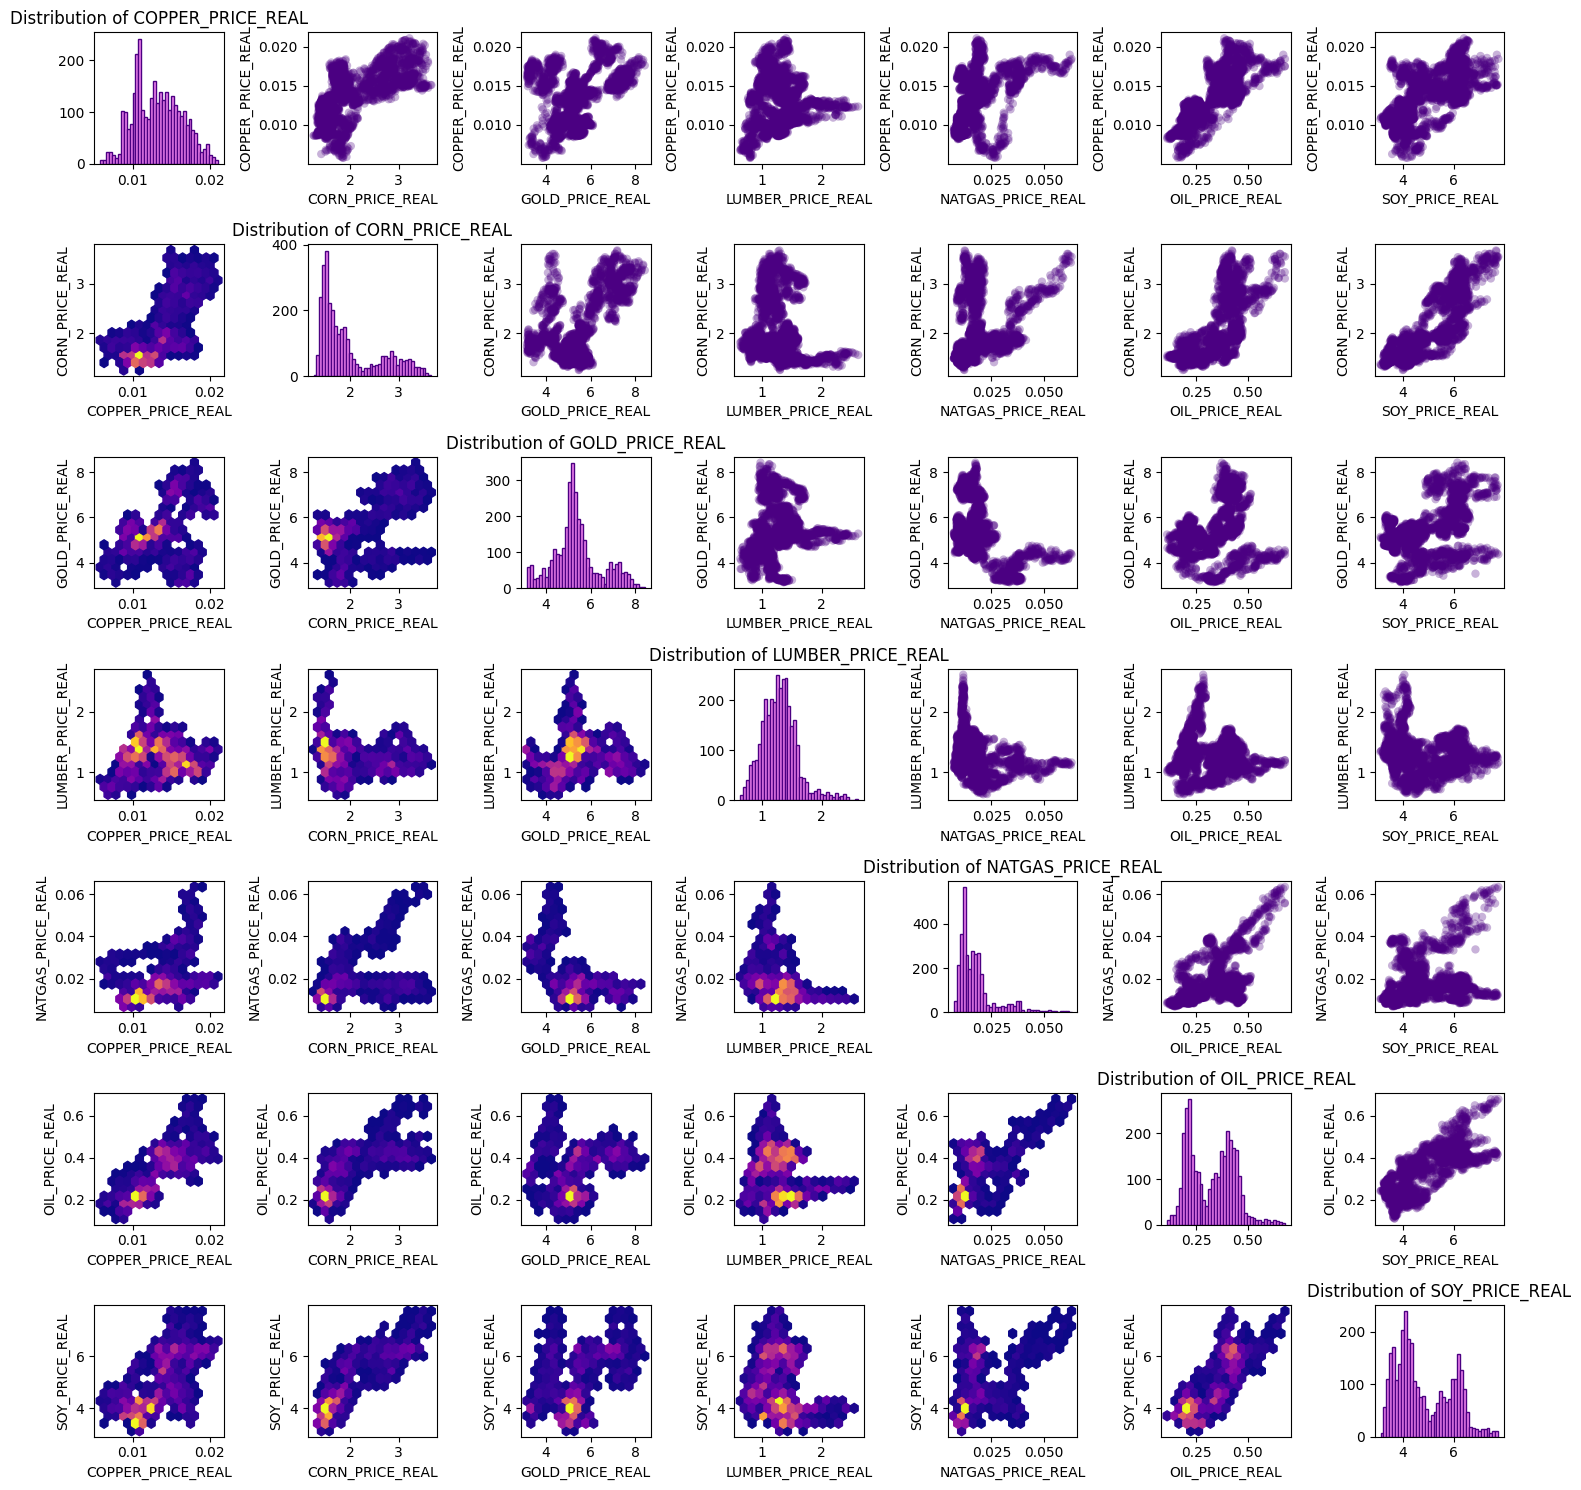

(<Figure size 1500x1500 with 49 Axes>,
 array([[<Axes: title={'center': 'Distribution of COPPER_PRICE_REAL'}>,
         <Axes: xlabel='CORN_PRICE_REAL', ylabel='COPPER_PRICE_REAL'>,
         <Axes: xlabel='GOLD_PRICE_REAL', ylabel='COPPER_PRICE_REAL'>,
         <Axes: xlabel='LUMBER_PRICE_REAL', ylabel='COPPER_PRICE_REAL'>,
         <Axes: xlabel='NATGAS_PRICE_REAL', ylabel='COPPER_PRICE_REAL'>,
         <Axes: xlabel='OIL_PRICE_REAL', ylabel='COPPER_PRICE_REAL'>,
         <Axes: xlabel='SOY_PRICE_REAL', ylabel='COPPER_PRICE_REAL'>],
        [<Axes: xlabel='COPPER_PRICE_REAL', ylabel='CORN_PRICE_REAL'>,
         <Axes: title={'center': 'Distribution of CORN_PRICE_REAL'}>,
         <Axes: xlabel='GOLD_PRICE_REAL', ylabel='CORN_PRICE_REAL'>,
         <Axes: xlabel='LUMBER_PRICE_REAL', ylabel='CORN_PRICE_REAL'>,
         <Axes: xlabel='NATGAS_PRICE_REAL', ylabel='CORN_PRICE_REAL'>,
         <Axes: xlabel='OIL_PRICE_REAL', ylabel='CORN_PRICE_REAL'>,
         <Axes: xlabel='SOY_PRICE_REAL',

In [26]:
columns = list(df.select_dtypes(include=np.number).columns)

#Filter out extraneous or nominal prices 
#  all macro indicators
columns = [col for col in columns 
           if '_LOW' not in col
             and '_HIGH' not in col
               and '_OPEN' not in col
               and '_NOMINAL' not in col
               and '_NOLAG' not in col
               and 'LAG90' not in col
               and 'VIX' not in col
               and 'R2000' not in col
               and 'SP500' not in col
               and 'HOUSE' not in col
               and 'TARGET' not in col]

vis.plot_feature_correlation_matrix(dev_data.to_pandas()[columns])

In the line charts, it's clear that there's a degree of independence even in commodities that are often highly correlated.  Even corn and soy see some periods of dispersion.  What we don't see, at least at this scale, is any straightforward, consistent indicator of a leading/lagging relationship between copper and another commodity.  

Copper tracks closely with gold for much of the dev period, for example, but which is leading varies. Spikes and troughs in copper and corn or soy also tend to coincide, but again, which is leading varies.  

There are periods where lumber and copper track very closely--something I'd expect due to the relationship with housing--and for a few years lumber clearly leads.  But for most of the dev period, they're relatively untethered.



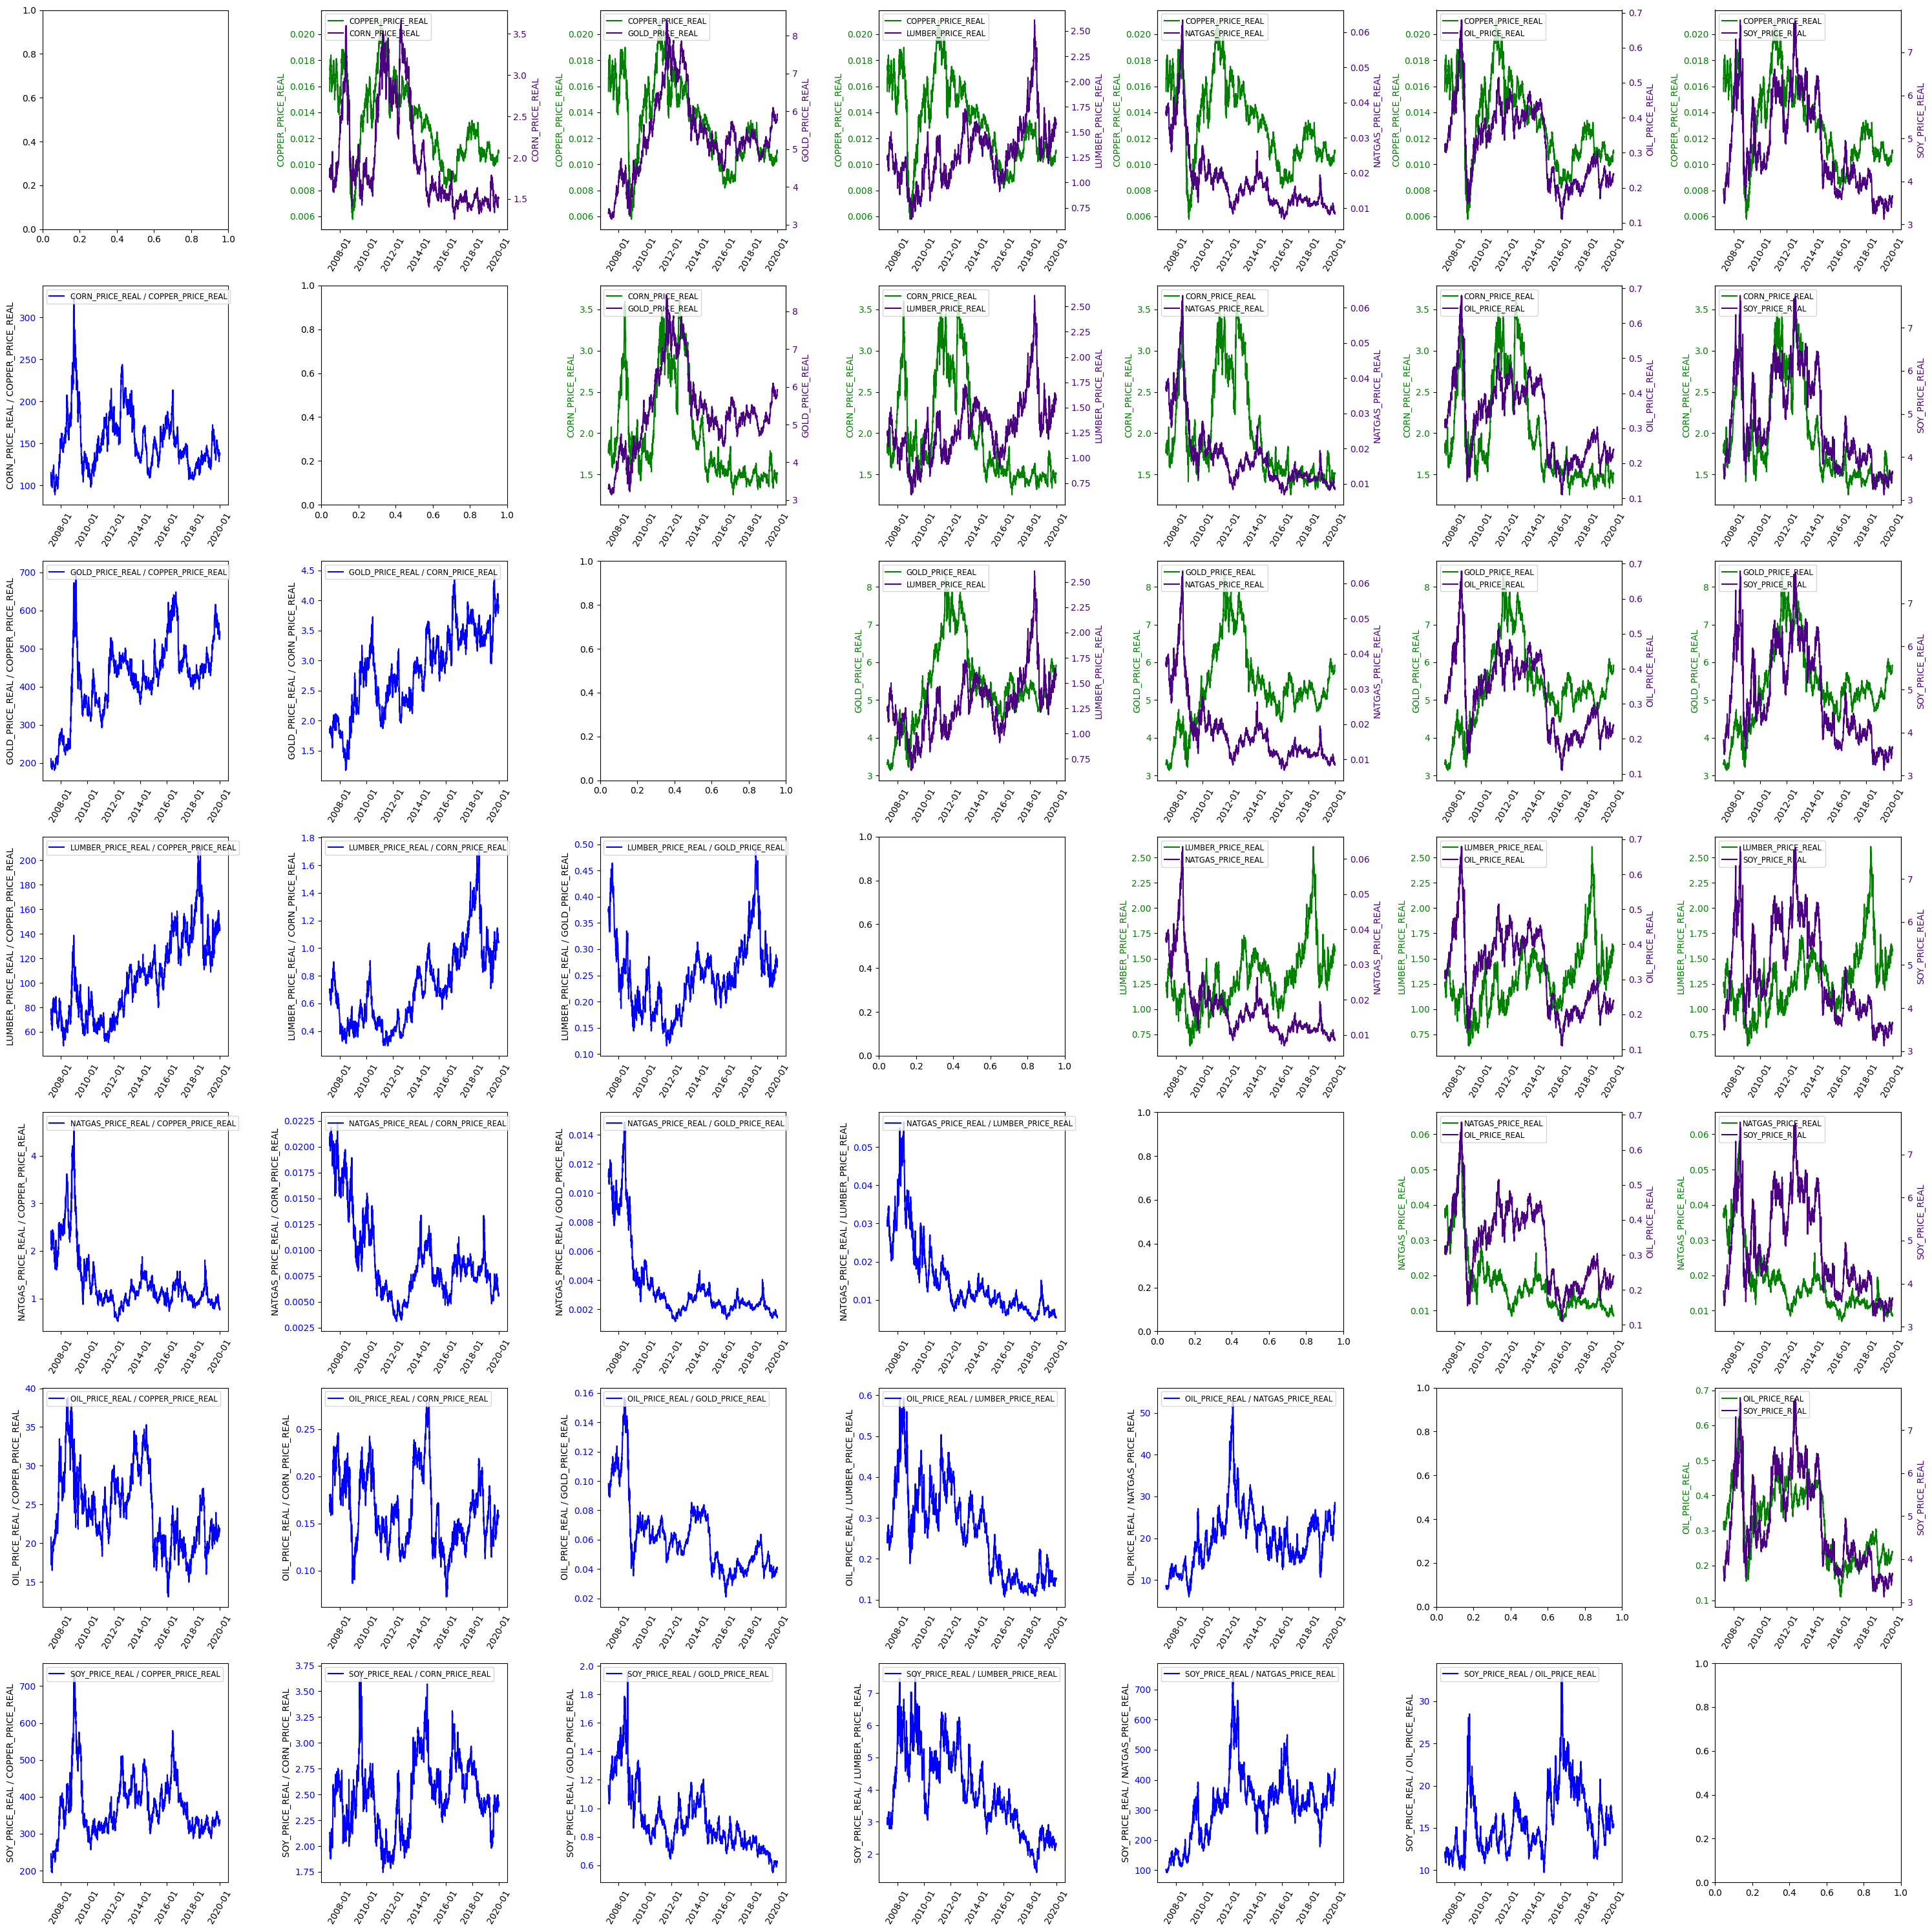

(<Figure size 3000x3000 with 70 Axes>,
 array([[<Axes: >, <Axes: ylabel='COPPER_PRICE_REAL'>,
         <Axes: ylabel='COPPER_PRICE_REAL'>,
         <Axes: ylabel='COPPER_PRICE_REAL'>,
         <Axes: ylabel='COPPER_PRICE_REAL'>,
         <Axes: ylabel='COPPER_PRICE_REAL'>,
         <Axes: ylabel='COPPER_PRICE_REAL'>],
        [<Axes: ylabel='CORN_PRICE_REAL / COPPER_PRICE_REAL'>, <Axes: >,
         <Axes: ylabel='CORN_PRICE_REAL'>,
         <Axes: ylabel='CORN_PRICE_REAL'>,
         <Axes: ylabel='CORN_PRICE_REAL'>,
         <Axes: ylabel='CORN_PRICE_REAL'>,
         <Axes: ylabel='CORN_PRICE_REAL'>],
        [<Axes: ylabel='GOLD_PRICE_REAL / COPPER_PRICE_REAL'>,
         <Axes: ylabel='GOLD_PRICE_REAL / CORN_PRICE_REAL'>, <Axes: >,
         <Axes: ylabel='GOLD_PRICE_REAL'>,
         <Axes: ylabel='GOLD_PRICE_REAL'>,
         <Axes: ylabel='GOLD_PRICE_REAL'>,
         <Axes: ylabel='GOLD_PRICE_REAL'>],
        [<Axes: ylabel='LUMBER_PRICE_REAL / COPPER_PRICE_REAL'>,
         <Axes: yla

In [33]:
columns = dev_data.to_pandas().columns

# Filter out extraneous or nominal prices 
# as well as lagged macro indicators
# and price targets 
columns = [col for col in columns 
           if '_LOW' not in col
             and '_HIGH' not in col
               and '_OPEN' not in col
               and '_NOMINAL' not in col
               and '_NOLAG' not in col
               and 'LAG90' not in col
               and 'VIX' not in col
               and 'R2000' not in col
               and 'SP500' not in col
               and 'HOUSE' not in col
               and 'TARGET' not in col
               and 'TRADING_DAY' not in col]

vis.plot_pairwise_time_series_matrix(
    dev_data.to_pandas()[columns], 
    left_color = 'green',
    right_color = 'indigo')

**Copper vs economic indicators** - Also shows a mix of straightfoward linear correlation and curious drift and multimodality.  While some of the linear correlation can be attributed to inflation, much of it cannot be over this time frame.

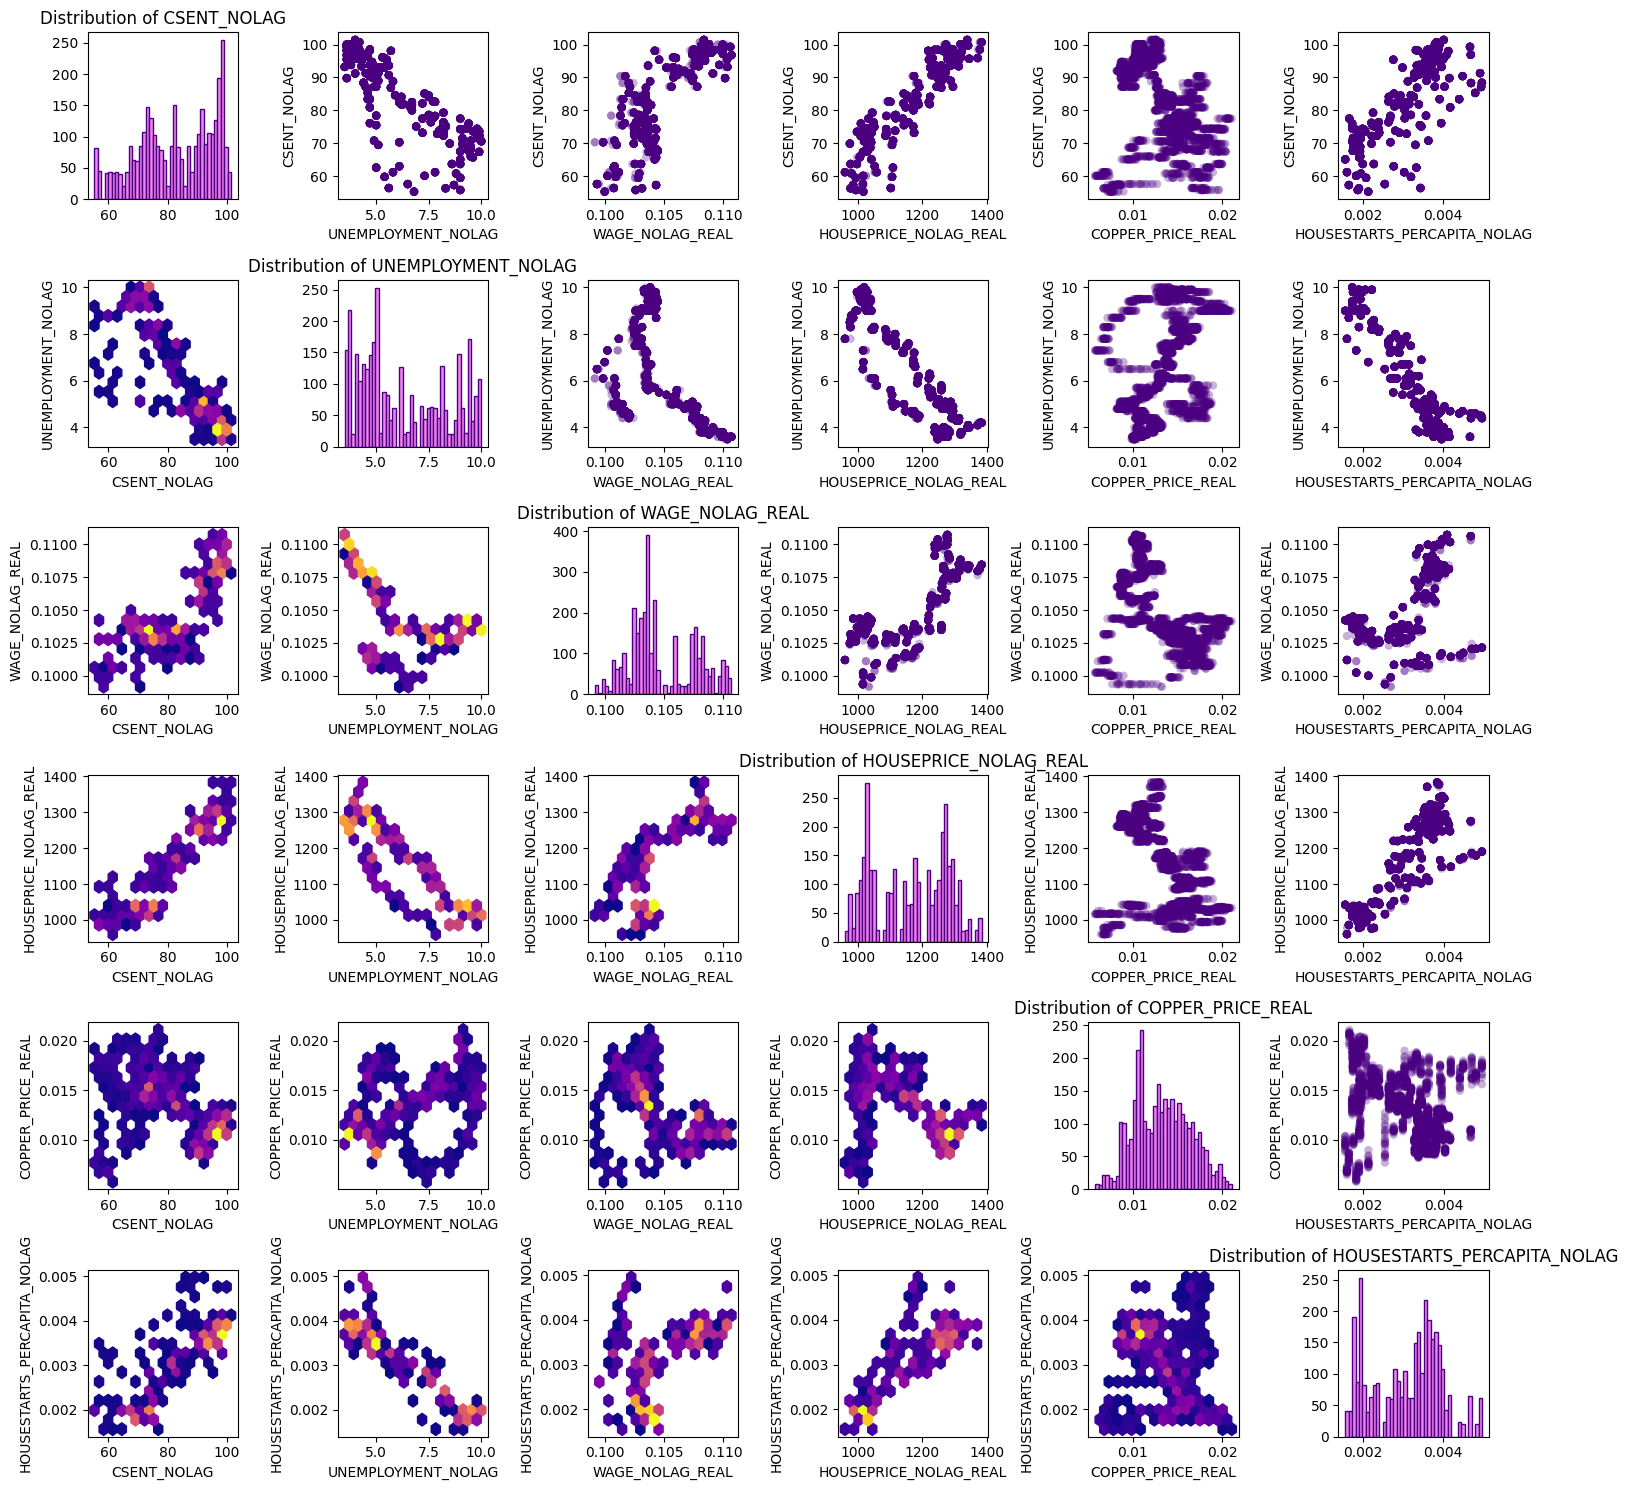

(<Figure size 1500x1500 with 36 Axes>,
 array([[<Axes: title={'center': 'Distribution of CSENT_NOLAG'}>,
         <Axes: xlabel='UNEMPLOYMENT_NOLAG', ylabel='CSENT_NOLAG'>,
         <Axes: xlabel='WAGE_NOLAG_REAL', ylabel='CSENT_NOLAG'>,
         <Axes: xlabel='HOUSEPRICE_NOLAG_REAL', ylabel='CSENT_NOLAG'>,
         <Axes: xlabel='COPPER_PRICE_REAL', ylabel='CSENT_NOLAG'>,
         <Axes: xlabel='HOUSESTARTS_PERCAPITA_NOLAG', ylabel='CSENT_NOLAG'>],
        [<Axes: xlabel='CSENT_NOLAG', ylabel='UNEMPLOYMENT_NOLAG'>,
         <Axes: title={'center': 'Distribution of UNEMPLOYMENT_NOLAG'}>,
         <Axes: xlabel='WAGE_NOLAG_REAL', ylabel='UNEMPLOYMENT_NOLAG'>,
         <Axes: xlabel='HOUSEPRICE_NOLAG_REAL', ylabel='UNEMPLOYMENT_NOLAG'>,
         <Axes: xlabel='COPPER_PRICE_REAL', ylabel='UNEMPLOYMENT_NOLAG'>,
         <Axes: xlabel='HOUSESTARTS_PERCAPITA_NOLAG', ylabel='UNEMPLOYMENT_NOLAG'>],
        [<Axes: xlabel='CSENT_NOLAG', ylabel='WAGE_NOLAG_REAL'>,
         <Axes: xlabel='UNEMPLO

In [34]:
df = dev_data.to_pandas()

# Get numeric columns - exclude dates
columns = list(df.select_dtypes(include=np.number).columns)

# Filter out extraneous or nominal prices 
# as well as lagged macro indicators
# and price targets 
columns = [col for col in columns 
           if '_LOW' not in col
             and '_HIGH' not in col
               and '_OPEN' not in col
               and '_LAG90' not in col
               and 'TARGET' not in col
               and 'NOMINAL' not in col
               and 'POP_' not in col
               and 'CPI_' not in col]

# Filter out prices other than copper
columns = [col for col in columns 
           if '_PRICE' not in col
           or 'COPPER' in col]


vis.plot_feature_correlation_matrix(
    dev_data.to_pandas()[columns])

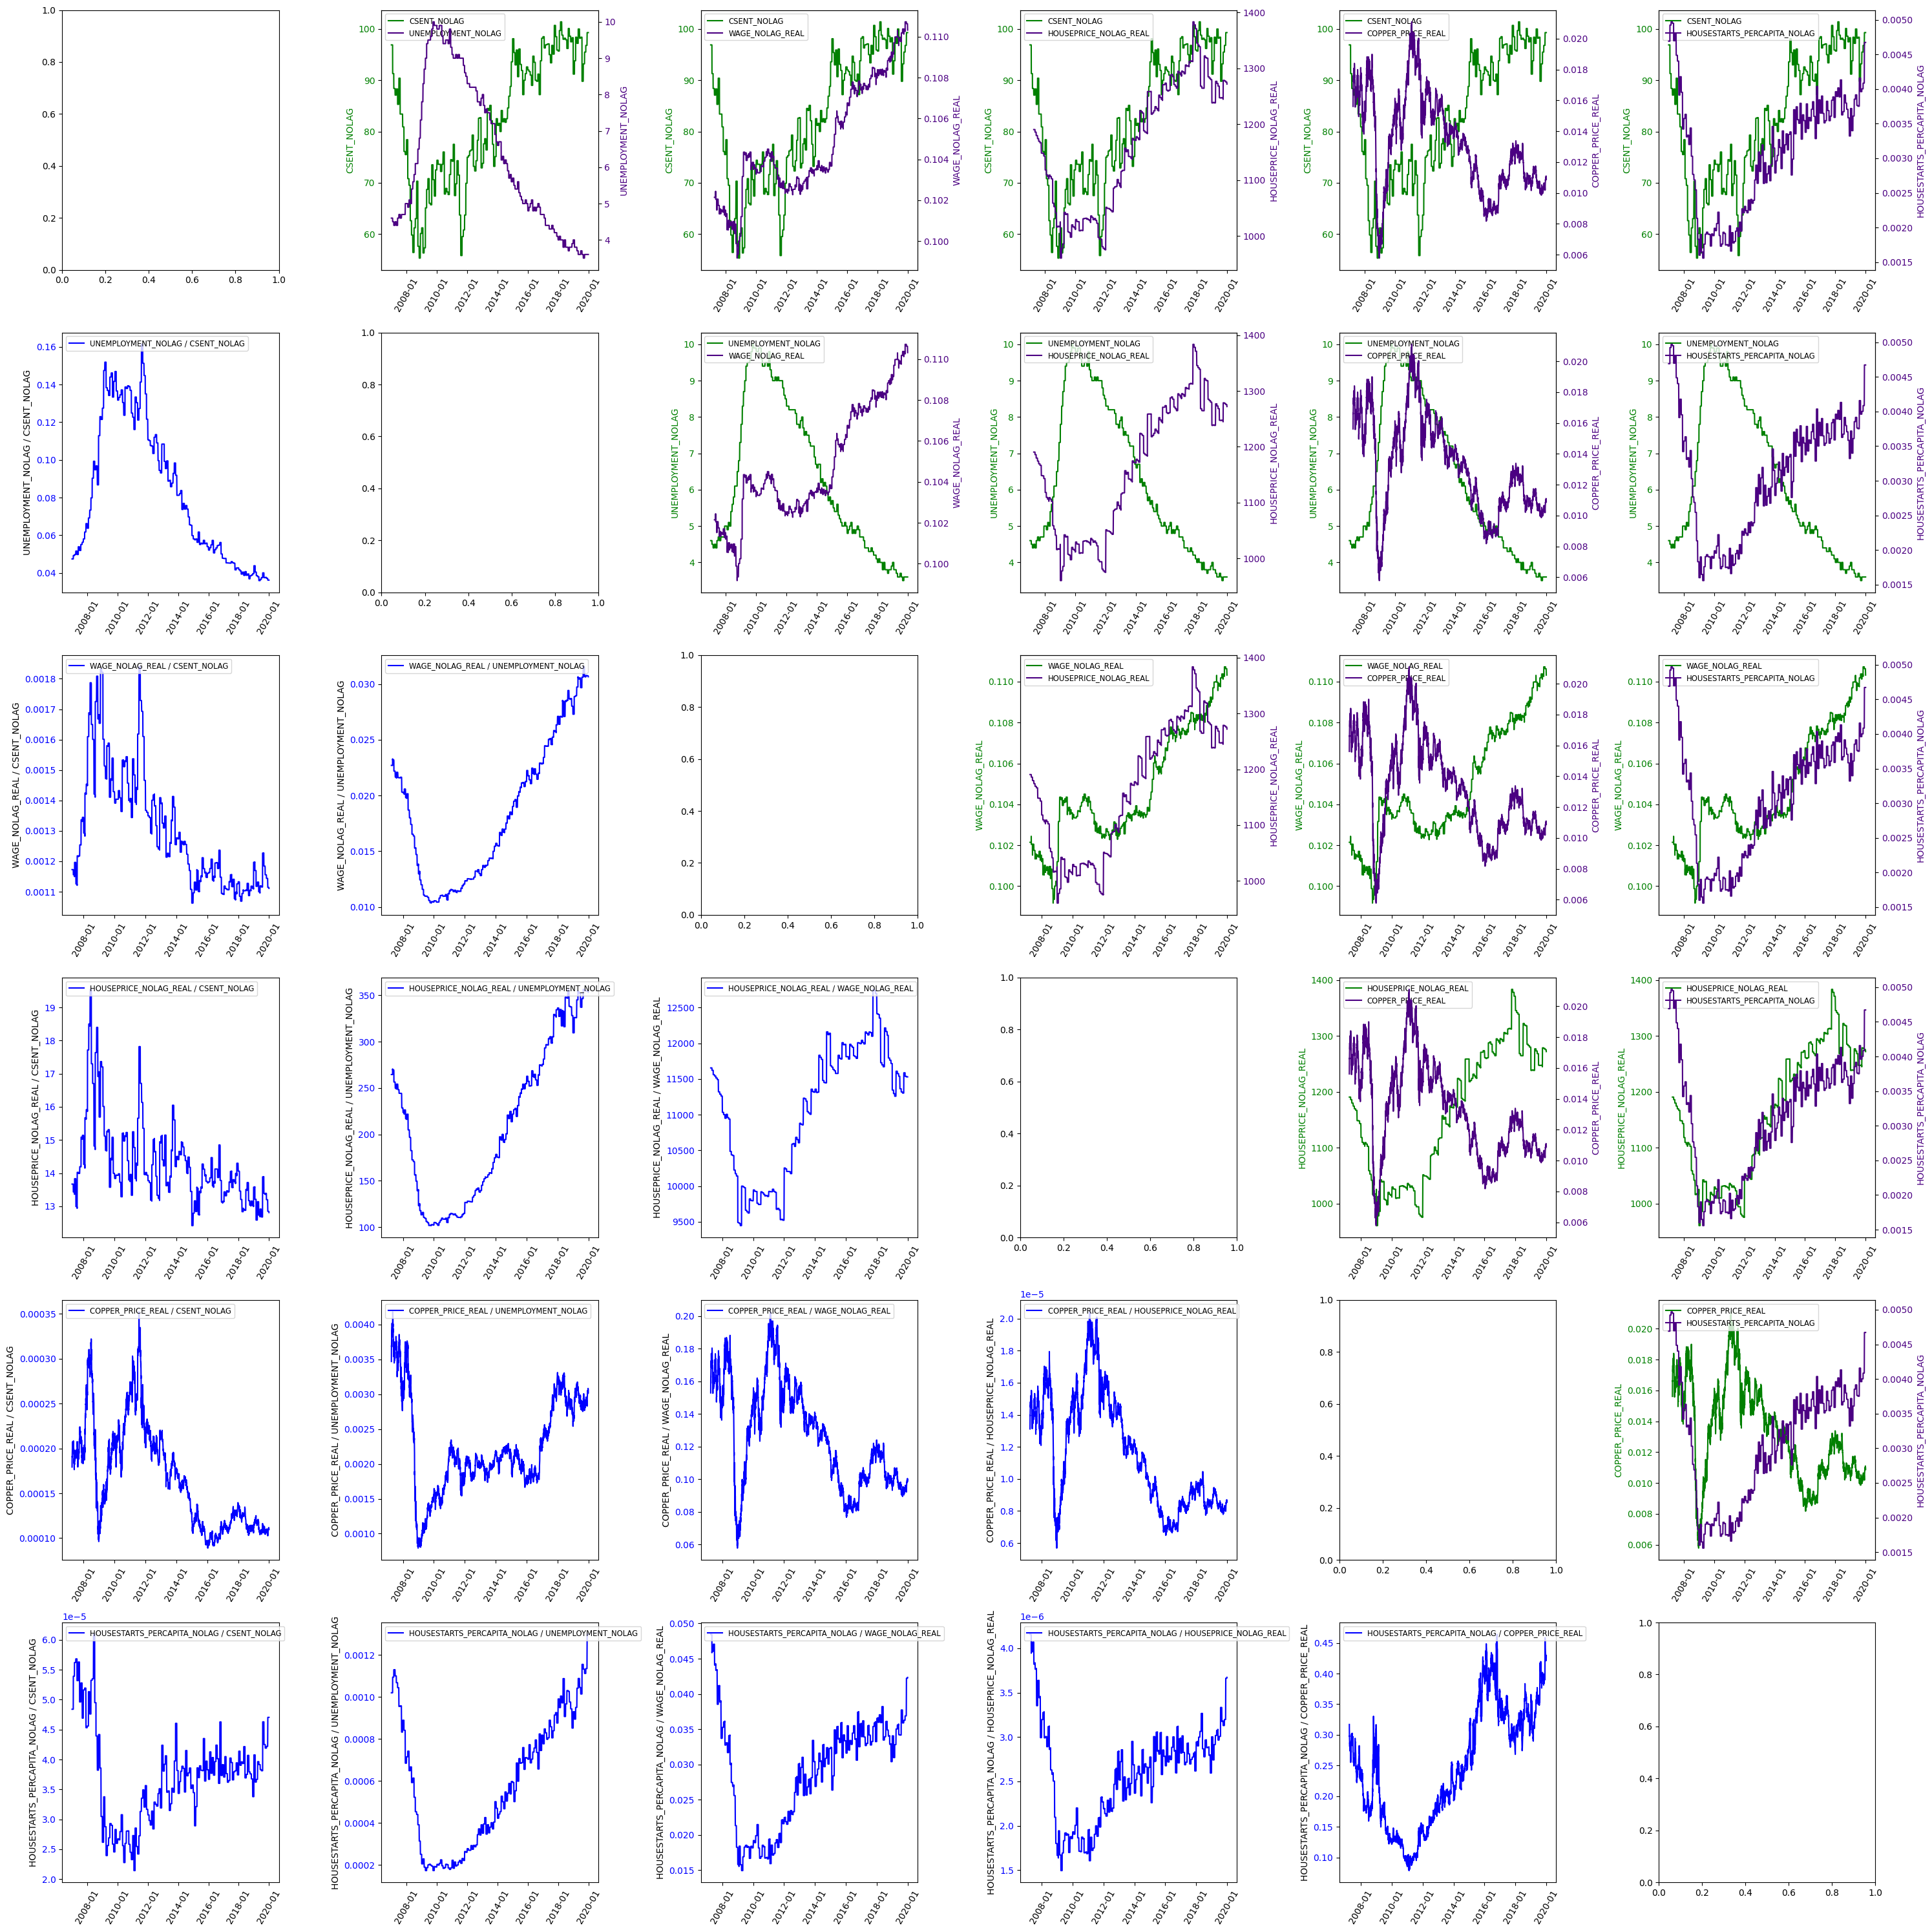

(<Figure size 3000x3000 with 51 Axes>,
 array([[<Axes: >, <Axes: ylabel='CSENT_NOLAG'>,
         <Axes: ylabel='CSENT_NOLAG'>, <Axes: ylabel='CSENT_NOLAG'>,
         <Axes: ylabel='CSENT_NOLAG'>, <Axes: ylabel='CSENT_NOLAG'>],
        [<Axes: ylabel='UNEMPLOYMENT_NOLAG / CSENT_NOLAG'>, <Axes: >,
         <Axes: ylabel='UNEMPLOYMENT_NOLAG'>,
         <Axes: ylabel='UNEMPLOYMENT_NOLAG'>,
         <Axes: ylabel='UNEMPLOYMENT_NOLAG'>,
         <Axes: ylabel='UNEMPLOYMENT_NOLAG'>],
        [<Axes: ylabel='WAGE_NOLAG_REAL / CSENT_NOLAG'>,
         <Axes: ylabel='WAGE_NOLAG_REAL / UNEMPLOYMENT_NOLAG'>, <Axes: >,
         <Axes: ylabel='WAGE_NOLAG_REAL'>,
         <Axes: ylabel='WAGE_NOLAG_REAL'>,
         <Axes: ylabel='WAGE_NOLAG_REAL'>],
        [<Axes: ylabel='HOUSEPRICE_NOLAG_REAL / CSENT_NOLAG'>,
         <Axes: ylabel='HOUSEPRICE_NOLAG_REAL / UNEMPLOYMENT_NOLAG'>,
         <Axes: ylabel='HOUSEPRICE_NOLAG_REAL / WAGE_NOLAG_REAL'>,
         <Axes: >, <Axes: ylabel='HOUSEPRICE_NOLAG_REAL'>

In [35]:
columns = dev_data.to_pandas().columns

# Filter out extraneous or nominal prices 
# as well as lagged macro indicators
# and price targets 
columns = [col for col in columns 
           if '_LOW' not in col
             and '_HIGH' not in col
               and '_OPEN' not in col
               and '_LAG90' not in col
               and 'TARGET' not in col
               and 'NOMINAL' not in col
               and 'POP_' not in col
               and 'CPI_' not in col
               and 'TRADING_DAY' not in col]

# Filter out prices other than copper
columns = [col for col in columns 
           if '_PRICE' not in col
           or 'COPPER' in col]

vis.plot_pairwise_time_series_matrix(
    dev_data.to_pandas()[columns], 
    left_color = 'green',
    right_color = 'indigo')